In [29]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
from vol_calcs import HorizontalSkew
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [125]:
engine = sql.create_engine("postgresql://postgres2@localhost/optiondata")
data = pd.read_sql("SELECT * FROM horizontal_skew WHERE symbol='NDX' ORDER BY date ASC", engine)

In [126]:
result_dict = {}
for date in data.date.unique():
    # Select date with date and sort by expiry
    select = data[data['date'] == date].sort_values(by='expiry')
    x_data = select['dte']
    y_data = select['vol_factor']
    # Fit model to selected data
    start = np.ones(3)
    model = least_squares(HorizontalSkew._fit_function, start, loss="soft_l1", f_scale=0.15, args=(x_data, y_data))
    # Generate 252 length data using model
    x_cont = np.arange(252)
    model_data = HorizontalSkew._fit_function(model.x, x_cont, 0)
    # Put in dict with date as key
    result_dict[select['date'].iloc[0]] = model_data
# Compile dict into dataframe with columns as each date
result = pd.DataFrame(result_dict)

In [110]:
# Same as above but without the model. Just selects 10th expiry out
result_dict = {}
for date in data.date.unique():
    select = data[data['date'] == date].sort_values(by='expiry')
    date = select['date'].iloc[0]
    vol = select['vol_factor'].iloc[10]
    result_dict[date] = vol
result = pd.Series(result_dict)

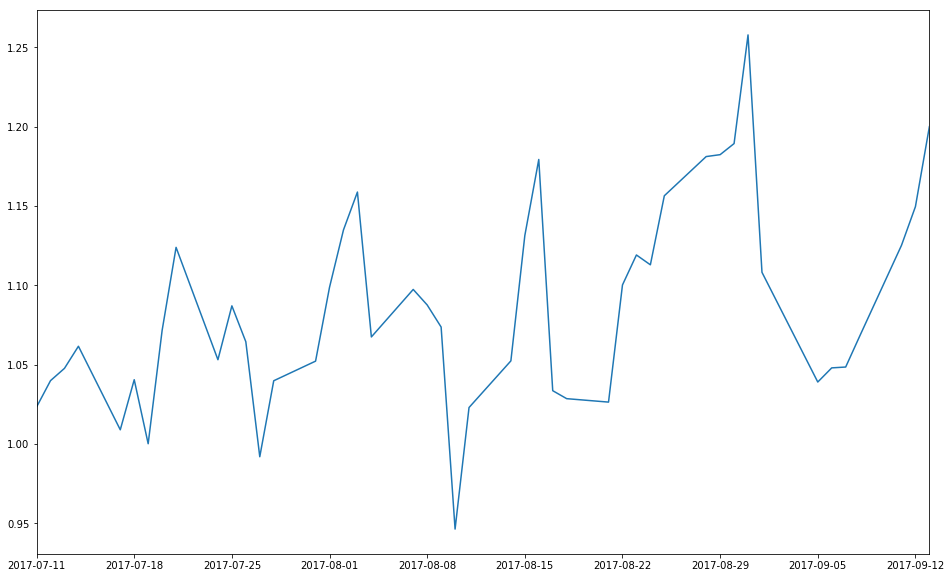

In [127]:
result.iloc[30].plot()

In [128]:
result.iloc[30].mean()

1.085424694442755